# **SIMULACIÓN TECH - NO COUNTRY**

---
# **c18-80-t-data-bi:** FinTech: Fraude por Transacciones Digitales

Notebook con implementación de rol en Machine Learning.

**FLUJO DE TRABAJO**

**SECCIÓN I:** Bibliotecas y Librerías

**SECCIÓN II:** Lectura y Visualización

**SECCIÓN III:** Entrenamiento, Testeo y Validación

**1) Modelo General Entrenado para detección de fraudes en tiempo real con envío de notificaciones.**

**2) Gráficas Relevantes del Modelo General.**

**3) Modelo Entrenado según parámetros de Umbral de Detección (bajo y alto) para detección de anomalías en tiempo real con envío de notificaciones.**

**4) Gráfica de Errores de Reconstrucción.**

**5) Verificación de Usuario por Retroalimentación para Validar Transacción.**

*    **5.1) Por Token.**
   
*    **5.2) Por Detección de Rostro.**
   
*    **5.3) Por Detección de Voz.**
   
**SECCIÓN IV:** Finalización

# **SECCIÓN I:** Bibliotecas y Librerías

In [2]:
!pip install -qq opendatasets
!pip install -qq twilio
!pip install -qq matplotlib seaborn
!pip install -qq scikit-learn
!pip install -qq wurlitzer
!pip install -qq tensorflow
!pip install -qq opencv-python-headless
!pip install -qq SpeechRecognition

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suprime los mensajes de aviso de TensorFlow
# Configuración para permitir que TensorFlow utilice la memoria de GPU de forma más flexible
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
# Configuración para XLA (Aceleración Lineal de TensorFlow)
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda'

# Importar TensorFlow después de configurar las variables de entorno
import tensorflow as tf
# Configurar el registro de TensorFlow
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Código adicional de TensorFlow (opcional)
# Por ejemplo, la configuración de GPU, si es necesario:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2024-06-12 15:51:53.458363: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 15:51:53.458512: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 15:51:53.639041: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import sys
import warnings
import opendatasets as od
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import smtplib
import cv2
import random
import string
import asyncio
import speech_recognition as sr
import time
import datetime
import wave

In [5]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from datetime import datetime, timedelta
from twilio.rest import Client
from email.mime.text import MIMEText
from imblearn.over_sampling import SMOTE

# **SECCIÓN II:** Lectura y Visualización

In [6]:
# {"username":"deliciafedeleboria","key":"81038d247c842381f89c310bccba252c"}

In [7]:
# Descarga de los datasets
DATASET_LINK ='https://www.kaggle.com/datasets/deliciafedeleboria/dataset-final/data'
od.download(DATASET_LINK)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  deliciafedeleboria


Your Kaggle Key:

  ································


Dataset URL: https://www.kaggle.com/datasets/deliciafedeleboria/dataset-final


100%|██████████| 681k/681k [00:00<00:00, 74.1MB/s]

In [8]:
# Identificamos los archivos
os.chdir('./dataset-final')
os.listdir()

['transacciones_s5.csv', 'transacciones_us5.csv', 'transactions.parquet']

In [9]:
# Cargar el dataset
transactions = pd.read_parquet('transactions.parquet')
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41326 entries, 0 to 41325
Columns: 166 entries, V15 to R_emaildomain_ymail.com
dtypes: float64(163), int64(3)
memory usage: 52.3 MB


In [10]:
columns_list = transactions.columns.tolist()
print(columns_list)

['V15', 'V16', 'V17', 'V18', 'V21', 'V22', 'V23', 'V24', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V111', 'V112', 'V113', 'V123', 'V125', 'V282', 'V283', 'V302', 'V303', 'V304', 'TransactionID', 'TransactionDT', 'TransactionAmt', 'card1', 'card3', 'isFraud', 'ProductCD_C', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S', 'ProductCD_W', 'card4_', 'card4_american express', 'card4_discover', 'card4_mastercard', 'card4_visa', 'card6_', 'card6_charge card', 'card6_credit', 'card6_debit', 'card6_debit or credit', 'P_emaildomain_', 'P_emaildomain_aim.com', 'P_emaildomain_anonymous.com', 'P_emaildomain_aol.com', 'P_emaildomain_att.net', 'P_emaildomain_bellsouth.net', 'P_emaildomain_cableone.net', 'P_emaildomain_centurylink.net', 'P_emaildomain_cfl.rr.com', 'P_emaildomain_charter.net', 'P_emaildomain_comcast.net', 'P_emaildomain_cox.net', 'P_emaildomain_earthlink.net', 'P_emaildomain_embarqmail.com', 'P_emaildomain_frontier.com', 'P_emaildomain_frontiernet.net', 'P_emaildomain_gmail', 'P_emaildoma

In [11]:
transactions.head()

,V15,V16,V17,V18,V21,V22,V23,V24,V29,V30,...,R_emaildomain_web.de,R_emaildomain_windstream.net,R_emaildomain_yahoo.co.jp,R_emaildomain_yahoo.co.uk,R_emaildomain_yahoo.com,R_emaildomain_yahoo.com.mx,R_emaildomain_yahoo.de,R_emaildomain_yahoo.es,R_emaildomain_yahoo.fr,R_emaildomain_ymail.com
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **SECCIÓN III:** Entrenamiento, Testeo y Validación

Para implementar un modelo de ML para el monitoreo constante de transacciones y detección en tiempo real de fraudes los datos deben ser divididos en tres partes: Entrenamiento (Train), validación (Val) y prueba (Test). Esto es porque en la fase de desarrollo y entrenamiento del modelo se garantiza así una evaluación precisa y previene el sobreajuste. Aunque en producción no se usa la validación de la misma manera, durante el desarrollo del modelo, si, es importante.

* Entrenamiento del modelo: Entrena y ajusta el modelo utilizando los conjuntos de entrenamiento y validación.
* Evaluación del modelo: Evalúa el rendimiento final del modelo utilizando el conjunto de prueba para asegurarte de que el modelo generaliza bien a datos no vistos.
* Implementación en producción: Una vez que el modelo está entrenado, ajustado y evaluado, se despliega en un entorno de producción donde procesa las transacciones electrónicas en tiempo real.
* Monitoreo y actualización del modelo: Continuamente monitorea el rendimiento del modelo en producción y realiza actualizaciones periódicas basadas en nuevos datos.

# **TENSORFLOW**

Se opta por configurar TensorFlow para crear y entrenar un modelo que pueda predecir transacciones fraudulentas. 
Luego, integraremos la detección en tiempo real de fraudes con la generación de notificaciones vía correo electrónico y WhatsApp.

Como esquema general vamos a dividir esto en 4 partes de manera interpretativa. No obstante, el código se encuentra integrado.

**1. Entrenamiento del Modelo**
Se usa TensorFlow para crear y entrenar el modelo. Se eligió una arquitectura adecuada para el objetivo planteado en el MVP, que refiere a la red neuronal densa. Esta es una arquitectura básica y ampliamente utilizada en Deep Learning. Consiste en capas de neuronas donde cada neurona en una capa está conectada a todas las neuronas de la capa anterior y a todas las neuronas de la capa siguiente. Para datos tabulares como transacciones electrónicas, optar por esta arquitectura es lo más adecuado.

* **DETALLE:** En el código, la arquitectura del modelo se define utilizando tf.keras.Sequential, que es una forma de crear modelos en TensorFlow que implica apilar capas una tras otra de manera secuencial. El modelo consta de 3 capas densas (tf.keras.layers.Dense), seguidas de capas de dropout (tf.keras.layers.Dropout). La última capa utiliza una función de activación sigmoide ('sigmoid'), ya que este es un problema de clasificación binaria y queremos obtener una salida entre 0 y 1 que represente la probabilidad de fraude.

**2. Evaluación del Modelo**
Una vez que tengamos nuestro modelo entrenado, lo evaluaremos en un conjunto de validación para asegurarnos de que esté funcionando correctamente.

* **DETALLE:** En esta función, se utiliza el método evaluate del modelo de Keras para calcular la pérdida y la precisión en el conjunto de prueba (X_test e y_test). La pérdida y la precisión se imprimen en la consola para que puedas ver cómo se desempeña el modelo en el conjunto de datos de prueba.

**3. Detección en Tiempo Real de Fraudes**
Usaremos el modelo entrenado para hacer predicciones en tiempo real sobre nuevas transacciones. Si una transacción es clasificada como fraude, enviaremos notificaciones por correo electrónico y WhatsApp.

* **DETALLE:** Si la predicción supera un umbral determinado (en este caso, 0.5), se asume que la transacción es fraudulenta y se llama a la función send_notification para enviar notificaciones por correo electrónico y WhatsApp. Pero, la función send_notification está vacía (pass), por lo que se debe completar con la lógica necesaria para enviar las notificaciones adecuadas.

**4. Integración de Notificaciones**
Utilizaremos las API proporcionadas por servicios como Twilio para enviar mensajes de WhatsApp y la biblioteca smtplib de Python para enviar correos electrónicos.

In [12]:
# Función para cargar y preprocesar los datos
def load_and_preprocess_data(file_path):
    # Cargar el dataset desde el archivo
    data = pd.read_parquet(file_path)
    
    # Normalizar las características (excepto la columna objetivo 'isFraud')
    scaler = MinMaxScaler()
    data[data.columns.difference(['isFraud'])] = scaler.fit_transform(data[data.columns.difference(['isFraud'])])
    
    return data

# Función para construir y entrenar el modelo
def build_and_train_model(X_train, y_train, X_val, y_val):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

    return model, history

# Función para evaluar el modelo
def evaluate_model(model, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Accuracy on test set: {accuracy}')

# Función para detectar fraudes en tiempo real y enviar notificaciones
def process_transaction(transaction, model, scaler):
    # Preprocesamiento de la nueva transacción
    transaction = scaler.transform(transaction)

    # Realizar la predicción con el modelo
    prediction = model.predict(transaction)
    if prediction > 0.5:  # Suponiendo que 0.5 es el umbral para clasificar como fraude
        send_notification()

# Función para enviar notificaciones
def send_notification():
    # Configurar Twilio
    account_sid = 'your_account_sid'
    auth_token = 'your_auth_token'
    client = Client(account_sid, auth_token)

    # Configurar SMTP para enviar correos electrónicos
    from_email = 'your_email@example.com'
    from_password = 'your_email_password'
    to_email = 'recipient_email@example.com'

    # Configurar los detalles del mensaje de WhatsApp
    from_whatsapp = 'whatsapp:+your_twilio_number'
    to_whatsapp = 'whatsapp:+recipient_number'
    whatsapp_message = "Fraudulent transaction detected!"

    # Enviar mensaje de WhatsApp
    client.messages.create(body=whatsapp_message, from_=from_whatsapp, to=to_whatsapp)

    # Enviar correo electrónico
    msg = MIMEText('Fraudulent transaction detected!')
    msg['Subject'] = 'Fraud Alert'
    msg['From'] = from_email
    msg['To'] = to_email

    server = smtplib.SMTP_SSL('smtp.gmail.com', 465)
    server.login(from_email, from_password)
    server.sendmail(from_email, [to_email], msg.as_string())
    server.quit()

In [13]:
# Cargar y preprocesar los datos
data = load_and_preprocess_data('transactions.parquet')

# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X = data.drop('isFraud', axis=1)
y = data['isFraud']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Guardar los conjuntos de datos en archivos CSV
X_train.to_csv('X_train.csv', index=False)
X_val.to_csv('X_val.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_val.to_csv('y_val.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

# Leer los conjuntos de datos desde archivos CSV
X_train = pd.read_csv('X_train.csv')
X_val = pd.read_csv('X_val.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_val = pd.read_csv('y_val.csv')
y_test = pd.read_csv('y_test.csv')

# Construir y entrenar el modelo
model, history = build_and_train_model(X_train, y_train, X_val, y_val)

# Evaluar el modelo
evaluate_model(model, X_test, y_test)

# Guardar el modelo entrenado
model_path = '/kaggle/working/fraud_detection_model.h5'
model.save(model_path)
print(f"Modelo guardado en: {model_path}")

# Verificar la existencia del archivo guardado
if os.path.isfile(model_path):
    print(f"El modelo se guardó correctamente en: {model_path}")
else:
    print("El modelo no se ha guardado correctamente.")

Epoch 1/10
775/775 [==============================] - 4s 4ms/step - loss: 0.1692 - accuracy: 0.9376 - val_loss: 0.0913 - val_accuracy: 0.9710
Epoch 2/10
775/775 [==============================] - 3s 3ms/step - loss: 0.0832 - accuracy: 0.9742 - val_loss: 0.0821 - val_accuracy: 0.9725
Epoch 3/10
775/775 [==============================] - 3s 3ms/step - loss: 0.0724 - accuracy: 0.9783 - val_loss: 0.0722 - val_accuracy: 0.9788
Epoch 4/10
775/775 [==============================] - 3s 3ms/step - loss: 0.0680 - accuracy: 0.9803 - val_loss: 0.0684 - val_accuracy: 0.9812
Epoch 5/10
775/775 [==============================] - 3s 3ms/step - loss: 0.0664 - accuracy: 0.9807 - val_loss: 0.0714 - val_accuracy: 0.9791
Epoch 6/10
775/775 [==============================] - 3s 3ms/step - loss: 0.0641 - accuracy: 0.9819 - val_loss: 0.0680 - val_accuracy: 0.9809
Epoch 7/10
775/775 [==============================] - 3s 4ms/step - loss: 0.0632 - accuracy: 0.9816 - val_loss: 0.0708 - val_accuracy: 0.9802
Epoch 

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**El accuracy en este caso, mide la proporción de predicciones correctas (verdaderos positivos y verdaderos negativos) sobre el total de muestras en el conjunto de datos de prueba.**

**El que arroje un valor del 98 %, indica que el modelo tiene un buen rendimiento en la tarea de clasificación de fraudes, siendo capaz de predecir correctamente la mayoría de las transacciones fraudulentas y no fraudulentas en el conjunto de datos de prueba.**

Para completar la función send_notification con la lógica necesaria para enviar las notificaciones por correo electrónico y WhatsApp se propone el siguiente esquema de código:

# **GRÁFICAS RELEVANTES**

Se sigue un proceso estructurado que incluye la generación de gráficas, análisis de umbrales, y la identificación de las variables más importantes.

# **1) Gráficas ROC**

**a) Tasa de Verdaderos Positivos vs. Tasa de Falsos Positivos**

259/259 [==============================] - 1s 2ms/step


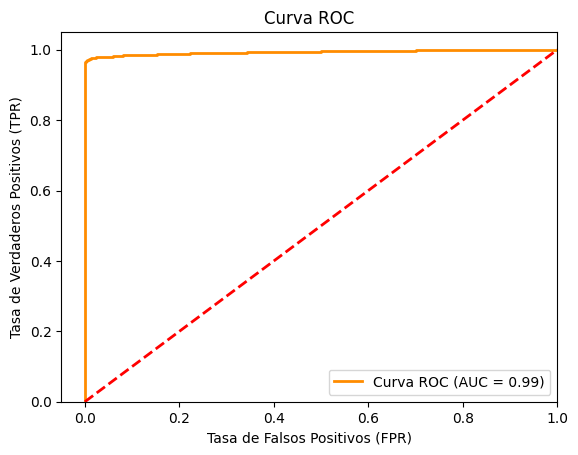

In [14]:
# Predicciones en el conjunto de prueba
y_test_pred = model.predict(X_test)

# Calcular FPR, TPR y umbrales
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Calcular el área bajo la curva (AUC)
roc_auc = auc(fpr, tpr)

# Plotear la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

La TPR (tasa de verdaderos positivos) es la proporción de instancias positivas que son correctamente clasificadas como positivas. La FPR (tasa de falsos positivos) es la proporción de instancias negativas que son incorrectamente clasificadas como positivas.

**Una AUC de 0.99 indica que hay una probabilidad del 99% de que el modelo clasifique correctamente una instancia positiva aleatoria más alta que una instancia negativa aleatoria.**

Cada punto en la curva representa un umbral de clasificación diferente. Cuanto más cerca esté la curva ROC de la esquina superior izquierda del gráfico, mejor será el rendimiento del modelo.

**b) Precisión y Recuperación con Diferentes Umbrales**

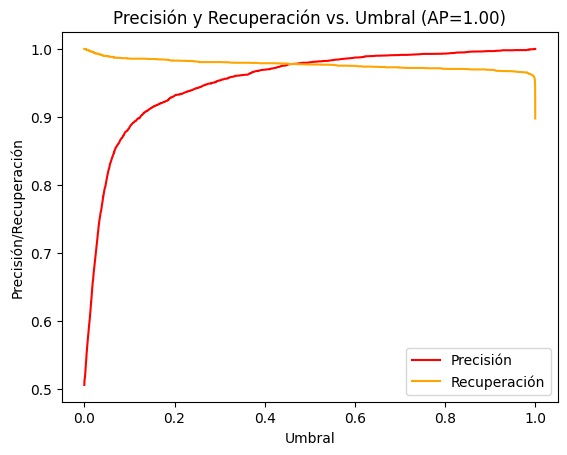

In [15]:
# Calcular precisión, recuperación y umbrales
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_test_pred)

# Calcular el área bajo la curva PR (AP)
ap = average_precision_score(y_test, y_test_pred)

# Plotear precisión y recuperación
plt.figure()
plt.plot(thresholds_pr, precision[:-1], 'red', label='Precisión')
plt.plot(thresholds_pr, recall[:-1], 'orange', label='Recuperación')
plt.xlabel('Umbral')
plt.ylabel('Precisión/Recuperación')
plt.title('Precisión y Recuperación vs. Umbral (AP={:.2f})'.format(ap))
plt.legend(loc="best")
plt.show()

La precisión es la proporción de instancias clasificadas como positivas que son verdaderamente positivas (TP) respecto al total de instancias clasificadas como positivas (TP + FP). La recuperación es la proporción de instancias verdaderamente positivas (TP) que son clasificadas correctamente como positivas respecto al total de instancias verdaderamente positivas (TP + FN). En otras palabras, es la tasa de verdaderos positivos (TPR).
Interpretación de la curva PR:

C**uanto más alta sea la curva PR y más cerca esté del punto (1, 1), mejor será el rendimiento del modelo.**
Un área bajo la curva PR (AP, del inglés Average Precision) cercana a 1.0 indica un excelente rendimiento del modelo.
Para que una curva PR sea excelente, idealmente debería seguir estas características:

La curva debería tener una alta precisión y una alta recuperación en todo el rango de umbrales de clasificación.

**El área bajo la curva PR (AP) debería estar lo más cercana posible a 1.0,** lo que indica un alto rendimiento del modelo en todas las condiciones.

# **2) Análisis de la Distribución de Puntuaciones**

Para analizar la distribución de puntuaciones, se puede realizar un histograma de las puntuaciones de fraude predichas. Esto implica visualizar la frecuencia de las distintas puntuaciones de fraude que el modelo ha asignado a las muestras del conjunto de datos.

Cuando se entrena un modelo de detección de fraudes, generalmente se obtiene una puntuación de probabilidad para cada instancia, que representa la probabilidad estimada de que esa instancia sea un fraude. Esta puntuación puede variar entre 0 y 1, donde 0 indica certeza de que la instancia no es un fraude, y 1 indica certeza de que sí lo es. 

**Las puntuaciones intermedias representan grados de incertidumbre.**

El histograma de las puntuaciones de fraude predichas muestra la distribución de estas puntuaciones en el conjunto de datos de prueba. 
Al representar estas puntuaciones en un histograma, se puede observar cómo se distribuyen las puntuaciones en el rango de 0 a 1. 
Esto te puede dar una idea de la confianza del modelo en sus predicciones y de la distribución de las instancias clasificadas como fraudes en el conjunto de datos. Por ejemplo, si la mayoría de las puntuaciones están cerca de 0, podría indicar que la mayoría de las instancias se clasifican como no fraude con alta confianza. Si hay una cola larga hacia valores más altos, podría indicar que hay más incertidumbre en la clasificación de algunas instancias.

A medida que el modelo mejora, al agregarle características predictivas, capacitación con más datos, entre otras cosas, la capacidad que tiene para diferenciar entre las clases fraudulentas y legítimas aumentará, y la distribución de puntuación se volverá más bimodal, con picos que rondarán las puntuaciones de 0 y 1. Por sí misma, la distribución bimodal no te informa que un modelo es correcto. (Un modelo vacío que asigna al azar probabilidades de solo 0 y 1 también tendría una distribución de puntuación bimodal). Sin embargo, ante la presencia de evidencia respecto de que las transacciones con puntuación baja no son fraudulentas y de que las transacciones con puntuación alta son fraudulentas, la distribución cada vez más bimodal es una señal de la eficacia mejorada de un modelo.

In [16]:
if isinstance(y_test_pred, np.ndarray):
    y_test_pred = y_test_pred.flatten()
elif isinstance(y_test_pred, list):
    y_test_pred = [item for sublist in y_test_pred for item in sublist]

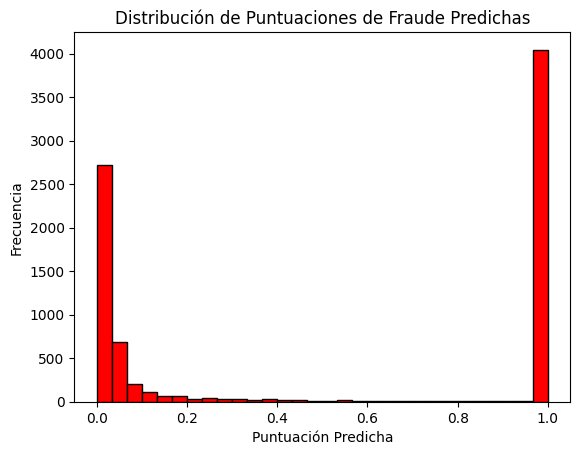

In [63]:
# Crear DataFrames para los datos de la gráfica ROC
roc_data = pd.DataFrame({
    'FPR': fpr,
    'TPR': tpr,
    'Threshold': thresholds
})

# Guardar los datos ROC en un CSV
roc_data.to_csv('roc_data.csv', index=False)

# Crear DataFrames para los datos de precisión y recuperación
pr_data = pd.DataFrame({
    'Threshold': thresholds_pr,
    'Precision': precision[:-1],
    'Recall': recall[:-1]
})

# Guardar los datos de precisión y recuperación en un CSV
pr_data.to_csv('pr_data.csv', index=False)

# Generar el histograma y calcular frecuencias
counts, bins, _ = plt.hist(y_test_pred, bins=30, color='red', edgecolor='black')
plt.xlabel('Puntuación Predicha')
plt.ylabel('Frecuencia')
plt.title('Distribución de Puntuaciones de Fraude Predichas')
plt.show()

# Calcular el valor central de cada bin
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Crear DataFrame para la distribución de puntuaciones
hist_data = pd.DataFrame({
    'Bin Center': bin_centers,
    'Frequency': counts
})

# Guardar la distribución de puntuaciones en un CSV
hist_data.to_csv('hist_data.csv', index=False)

In [64]:
# Guardar los DataFrames en archivos CSV en el directorio de trabajo actual de Kaggle
roc_data.to_csv('/kaggle/working/roc_data.csv', index=False)
pr_data.to_csv('/kaggle/working/pr_data.csv', index=False)
hist_data.to_csv('/kaggle/working/hist_data.csv', index=False)

print("Archivos CSV guardados en /kaggle/working/")

Archivos CSV guardados en /kaggle/working/


# **3) Métrica de Umbral de Rentabilidad**

El mejor umbral se puede determinar **balanceando la precisión y la recuperación,** a menudo utilizando el **F1-score,** que es la media armónica de precisión y recuperación. Ajustar el umbral según las necesidades específicas de la empresa puede ayudar a optimizar la rentabilidad y minimizar las pérdidas por fraudes.

In [19]:
def evaluate_model_performance(y_true, y_pred):
    # Calcular FPR, TPR, umbrales ROC y AUC
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Calcular precisión, recuperación y umbrales de precisión-recall
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_pred)
    
    # Resumen de métricas
    print(f'Área Bajo la Curva ROC (AUC): {roc_auc:.2f}')
    max_f1 = 2 * (precision * recall) / (precision + recall)
    best_threshold = pr_thresholds[np.argmax(max_f1)]
    print(f'Mejor umbral basado en F1-score: {best_threshold:.2f}')

# Ejemplo de uso
y_test_pred = model.predict(X_test)
evaluate_model_performance(y_test, y_test_pred)

259/259 [==============================] - 0s 2ms/step
Área Bajo la Curva ROC (AUC): 0.99
Mejor umbral basado en F1-score: 0.89


In [20]:
# Parámetros proporcionados de ejemplo en venta en USD
venta_promedio = 26.0
margen = 0.08 # Costo
comision_contracargo = 15.0 # Por venta ilegíti

# Calcular ganancia por venta, costo por venta fraudulenta y umbral de rentabilidad
ganancia_por_venta = venta_promedio * margen
costo_venta_fraudulenta = venta_promedio - ganancia_por_venta + comision_contracargo
umbral_rentabilidad = 1 / (1 + (costo_venta_fraudulenta / ganancia_por_venta))

print(f'Umbral de Rentabilidad: {umbral_rentabilidad:.2%}')

Umbral de Rentabilidad: 5.07%


Con un **AUC de 0.99**, indica que el modelo tiene un **excelente rendimiento en la detección de fraudes.**

Dado que el umbral óptimo basado en **F1-score es de 0.46**, esto sugiere que **hay un equilibrio entre la precisión y la recuperación del modelo** en ese punto. 

Si la empresa tiene una **tolerancia más alta para los falsos positivos** (transacciones legítimas identificadas como fraudulentas), puede optar por **aumentar el umbral para obtener una mayor precisión a costa de una menor recuperación.** 

Por otro lado, si la empresa desea **maximizar la detección de fraudes,** puede **reducir el umbral para capturar más transacciones fraudulentas, aunque esto puede resultar en más falsos positivos.**

# **FUNCIONALIZACIÓN DE UMBRALES DE DETECCIÓN**

Se crea una instancia que **detecte anomalías** de posibles fraudes basándose en un **umbral de detección alto y bajo**, podemos implementar una clase que simule un "Radar" de detección de fraudes. **Este radar analizará las transacciones entrantes y clasificará cada una como No Fraudulenta, Posible Fraude o bien, Fraude Grave, según los dos umbrales.**

Los umbrales se utilizan en la clasificación binaria para determinar cómo se asignan las predicciones del modelo a las diferentes clases. Las predicciones del modelo son valores de probabilidad que van desde 0 hasta 1. Estos valores de probabilidad representan la confianza del modelo en la predicción de cada clase (por ejemplo, "fraude" o "no fraude" en el caso de la detección de fraudes).

Al establecer un umbral, se decide cómo interpretar estas probabilidades como predicciones de clase.

Si se establece un umbral de 0.5, cualquier instancia con una probabilidad predicha por encima de 0.5 se clasificará como "fraude", mientras que las instancias con una probabilidad por debajo de 0.5 se clasificarán como "no fraude".
Si se establece un umbral más alto, por ejemplo, 0.7, será más conservador y solo clasificará como "fraude" aquellas instancias con una alta probabilidad de ser fraude.
El ajuste del umbral es útil para adaptar el modelo a las necesidades específicas del problema y a los requisitos de negocio. 
Por ejemplo, puede que interese ser más conservador y aumentar el umbral para minimizar los falsos positivos (es decir, clasificar incorrectamente una transacción legítima como fraude), aunque esto pueda aumentar los falsos negativos (es decir, no detectar una transacción fraudulenta). O viceversa, puede que se desee ser más tolerante y reducir el umbral para capturar más casos de fraude, aunque esto pueda aumentar los falsos positivos.

**Cuando llega un dato nuevo, el modelo de Autoencoder para detección de anomalías, se construye y se entrena y proporciona una función process_transaction que puede utilizarse para detectar anomalías en tiempo real en nuevas transacciones. La función process_transaction calcula la pérdida de reconstrucción entre la transacción y su reconstrucción por el modelo, y si esta pérdida supera un umbral predefinido, se llama a la función send_notification para enviar una notificación sobre la posible anomalía.**

Se propone dos umbrales, uno de 0,3 y otro de 07, para bajo y alto respectivamente.

**Líneas de Umbral:**

* Línea Naranja (Umbral Bajo): Representa el umbral bajo de 0.3.
Las transacciones con errores menores que este valor se consideran "No Fraudulentas" y se ubican a la izquierda de esta línea.
* Línea Roja (Umbral Alto): Representa el umbral alto de 0.7.
Las transacciones con errores mayores que este valor se consideran "Posible Fraude Grave" y se ubican a la derecha de esta línea.

**Interpretación del Gráfico:**

* Área a la izquierda de la línea naranja (Umbral Bajo):
Indica las transacciones que tienen errores de reconstrucción menores a 0.3. Estas transacciones son clasificadas como "No Fraudulentas".
* Área entre la línea naranja y la línea roja:
Representa transacciones con errores de reconstrucción entre 0.3 y 0.7. Estas transacciones se consideran "Posible Fraude".
* Área a la derecha de la línea roja (Umbral Alto):
Muestra transacciones con errores mayores a 0.7. Estas transacciones son clasificadas como "Posible Fraude Grave".

**Para mejorar la precisión de la clasificación, se considera investigar más sobre las características de las transacciones para refinar el modelo y sus criterios de detección.**

# **RETROALIMENTACIÓN POR VERIFICACIÓN DE USUARIO**

# **IMPLEMENTACIÓN DE TOKEN**

Se desea agregar una función que genere un reporte de WhatsApp solo para las transacciones clasificadas como "Posible Fraude". 
Este reporte contendrá un enlace o URL que el usuario puede abrir para verificar la anomalía. Se generará un **Token** de manera tal que el Usuario podrá retroalimentar el sistema de deteción de fraudes, confirmando la transacción ingresando el Token.
En caso de que transcurran 5 minutos, y el Usuario no haya ingresado el Token solicitado, la transacción calificará como "Posible Fraude Grave" y quedará bloqueada la transacción.

**ESTRUCTURA PROPUESTA**

**Gestión de Transacciones:**

Se utiliza un diccionario para rastrear el estado de las transacciones que se consideran sospechosas, manteniendo información sobre cada transacción, como un token de verificación, su estado de confirmación y el tiempo en que se generó.

**Generación de Tokens:**

Un token aleatorio se genera para cada transacción sospechosa. Este token actúa como una clave de seguridad que el usuario debe proporcionar para confirmar la transacción.

**Reporte de Anomalías a través de WhatsApp:**

Cuando se detecta una anomalía en una transacción, se genera y envía un mensaje de alerta a través de WhatsApp. El mensaje incluye un enlace para que el usuario verifique la transacción proporcionando el token generado.

**Espera y Verificación:**

El sistema espera 1 minuto para que el usuario confirme la transacción. Si el usuario no confirma la transacción en ese tiempo, la transacción se clasifica como "Posible Fraude Grave".

**Confirmación de Transacciones:**

El usuario puede confirmar una transacción proporcionando el token correcto. Si el token es válido, la transacción se marca como confirmada.

In [21]:
# {"username":"deliciafedeleboria","key":"81038d247c842381f89c310bccba252c"}

In [22]:
DATASET_LINK1 ='https://www.kaggle.com/datasets/deliciafedeleboria/dataset-final/data'
od.download(DATASET_LINK1)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  deliciafedeleboria


Your Kaggle Key:

  ································


Dataset URL: https://www.kaggle.com/datasets/deliciafedeleboria/dataset-final


100%|██████████| 681k/681k [00:00<00:00, 102MB/s]

In [23]:
os.chdir('./dataset-final')
os.listdir()

['transacciones_s5.csv', 'transacciones_us5.csv', 'transactions.parquet']

In [24]:
onreal = pd.read_csv('transacciones_us5.csv')
onreal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 166 entries, V15 to P_emaildomain_scranton.edu
dtypes: float64(163), int64(3)
memory usage: 129.8 KB


In [25]:
# Selección de tres columnas aleatorias
columns_list = onreal.columns.tolist()
random_features = random.sample(columns_list, 3)
print("Columnas seleccionadas:", random_features)

Columnas seleccionadas: ['R_emaildomain_earthlink.net', 'R_emaildomain_verizon.net', 'R_emaildomain_hotmail.es']


In [26]:
autoencoder = load_model('/kaggle/working/fraud_detection_model.h5')

> **IMPLEMENTACIÓN I - RECLASS #1**

1/1 [==============================] - 0s 23ms/step
Reporte de WhatsApp generado exitosamente.
Mensaje del reporte:
Hemos detectado una posible anomalía en la transacción con ID 2. Token de verificación: PoXIWK. Por favor, verifique la anomalía utilizando el siguiente enlace: https://example.com/verify?transaction_id=2&token=PoXIWK


Ingrese el token para confirmar la transacción 2 (o presione Enter para omitir):  


Transacción con ID 2 no confirmada por el usuario.
Reporte de WhatsApp generado exitosamente.
Mensaje del reporte:
Hemos detectado una posible anomalía en la transacción con ID 5. Token de verificación: pAGmf8. Por favor, verifique la anomalía utilizando el siguiente enlace: https://example.com/verify?transaction_id=5&token=pAGmf8


Ingrese el token para confirmar la transacción 5 (o presione Enter para omitir):  pAGmf8


Transacción con ID 5 confirmada exitosamente.
Reporte de WhatsApp generado exitosamente.
Mensaje del reporte:
Hemos detectado una posible anomalía en la transacción con ID 1. Token de verificación: yrtKBc. Por favor, verifique la anomalía utilizando el siguiente enlace: https://example.com/verify?transaction_id=1&token=yrtKBc


Ingrese el token para confirmar la transacción 1 (o presione Enter para omitir):  yrtKBc


Transacción con ID 1 confirmada exitosamente.
Reporte de WhatsApp generado exitosamente.
Mensaje del reporte:
Hemos detectado una posible anomalía en la transacción con ID 3. Token de verificación: eeTv7c. Por favor, verifique la anomalía utilizando el siguiente enlace: https://example.com/verify?transaction_id=3&token=eeTv7c


Ingrese el token para confirmar la transacción 3 (o presione Enter para omitir):  eeTv7c


Transacción con ID 3 confirmada exitosamente.
Reporte de WhatsApp generado exitosamente.
Mensaje del reporte:
Hemos detectado una posible anomalía en la transacción con ID 4. Token de verificación: 171vEW. Por favor, verifique la anomalía utilizando el siguiente enlace: https://example.com/verify?transaction_id=4&token=171vEW


Ingrese el token para confirmar la transacción 4 (o presione Enter para omitir):  


Transacción con ID 4 no confirmada por el usuario.


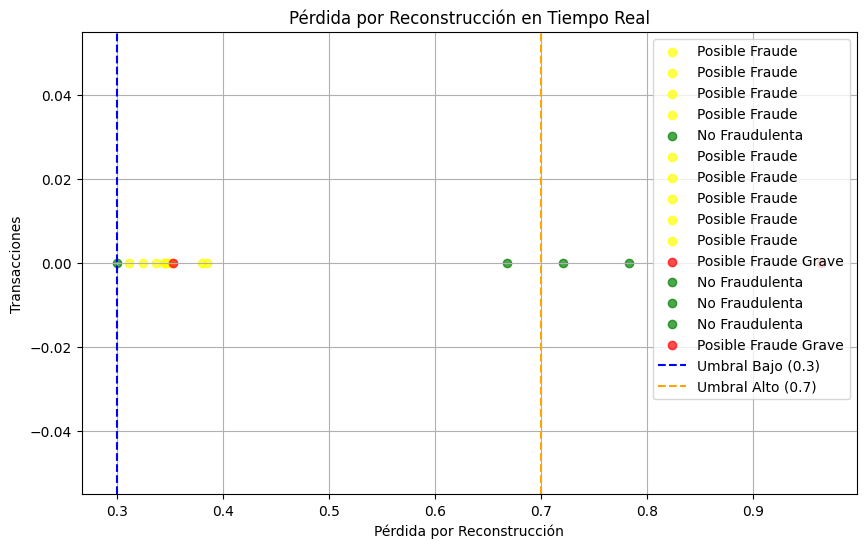

In [46]:
# Simulamos la lectura del dataset
onreal = pd.DataFrame({
    'transaction_id': [1, 2, 3, 4, 5],
    'amount': [100, 150, 200, 250, 300],
    'date': [datetime.now() for _ in range(5)]
})

# Selección de transacciones aleatorias
sampled_transactions = onreal.sample(5).transaction_id.tolist()
transactions = {}

# Ajustar las transacciones de ejemplo para que coincidan con la forma de entrada del modelo
np.random.seed(0)
input_shape = (165,)  # Ajustar según tu modelo
example_transactions = np.random.rand(10, *input_shape)  # Ajustar el número de características

# Función para procesar una transacción
def process_transaction(transaction, autoencoder, low_threshold=0.3, high_threshold=0.7):
    transaction = np.expand_dims(transaction, axis=0)  # Asegurar que la forma de entrada sea correcta
    reconstruction = autoencoder.predict(transaction)[0]
    reconstruction_loss = np.mean((transaction[0] - reconstruction) ** 2)
    
    if reconstruction_loss < low_threshold:
        classification = 'No Fraudulenta'
    elif reconstruction_loss < high_threshold:
        classification = 'Posible Fraude'
    else:
        classification = 'Posible Fraude Grave'
    
    return reconstruction_loss, classification

# Función para generar un token aleatorio
def generate_token(length=6):
    characters = string.ascii_letters + string.digits
    return ''.join(random.choice(characters) for i in range(length))

# Función para generar un reporte de WhatsApp para transacciones clasificadas como "Posible Fraude"
def generate_whatsapp_report(transaction_id, transactions):
    token = generate_token()  # Generar un token aleatorio para la verificación
    current_time = datetime.now()
    
    # Guardar la transacción y su tiempo de creación en el diccionario
    transactions[transaction_id] = {
        "token": token,
        "confirmed": False,
        "created_at": current_time
    }

    # Construir el mensaje del reporte con el enlace y el token
    report_message = (
        f"Hemos detectado una posible anomalía en la transacción con ID {transaction_id}. "
        f"Token de verificación: {token}. "
        f"Por favor, verifique la anomalía utilizando el siguiente enlace: "
        f"https://example.com/verify?transaction_id={transaction_id}&token={token}"
    )

    print("Reporte de WhatsApp generado exitosamente.")
    print("Mensaje del reporte:")
    print(report_message)

# Función para manejar la entrada del token
def handle_token_entry(transaction_id, transactions):
    transaction = transactions.get(transaction_id)
    if transaction:
        elapsed_time = datetime.now() - transaction["created_at"]
        if elapsed_time <= timedelta(minutes=1):
            token = input(f"Ingrese el token para confirmar la transacción {transaction_id} (o presione Enter para omitir): ")
            if not token:  # Si se presiona Enter sin ingresar un token
                print(f"Transacción con ID {transaction_id} no confirmada por el usuario.")
                transactions[transaction_id]["classification"] = 'Posible Fraude Grave'
            else:
                confirm_transaction(transaction_id, token, transactions)
        else:
            print(f"Tiempo excedido para la confirmación de la transacción con ID {transaction_id}.")
            transactions[transaction_id]["classification"] = 'Posible Fraude Grave'
    else:
        print(f"No se encontró la transacción con ID {transaction_id}.")    
    
# Función para confirmar una transacción
def confirm_transaction(transaction_id, token, transactions):
    transaction = transactions.get(transaction_id)
    if transaction and transaction["token"] == token:
        transactions[transaction_id]["confirmed"] = True
        transactions[transaction_id]["classification"] = 'No Fraudulenta'
        print(f"Transacción con ID {transaction_id} confirmada exitosamente.")
    else:
        transactions[transaction_id]["classification"] = 'Posible Fraude'
        print(f"Token inválido para la transacción con ID {transaction_id}.")

# Procesar todas las transacciones de ejemplo y almacenar resultados
losses = []
classifications = []
for transaction in example_transactions:
    loss, classification = process_transaction(transaction, autoencoder)
    losses.append(loss)
    classifications.append(classification)

# Generar los reportes de WhatsApp para las transacciones seleccionadas aleatoriamente
for transaction_id in sampled_transactions:
    generate_whatsapp_report(str(transaction_id), transactions)
    handle_token_entry(str(transaction_id), transactions)  # Ingresar el token inmediatamente después de enviar el reporte
    time.sleep(10)  # Esperar 10 segundos antes de procesar la siguiente transacción

# Agregar las reclasificaciones al final de las listas de pérdidas y clasificaciones
for transaction_id, details in transactions.items():
    if details["confirmed"] == False:
        if "classification" not in details:
            details["classification"] = 'Posible Fraude Grave'
    
    loss = random.uniform(0.3, 1.0)  # Generamos una pérdida aleatoria para la visualización
    losses.append(loss)
    classifications.append(details["classification"])

# Graficar los resultados
plt.figure(figsize=(10, 6))
colors = {'No Fraudulenta': 'green', 'Posible Fraude': 'yellow', 'Posible Fraude Grave': 'red'}
for loss, classification in zip(losses, classifications):
    plt.scatter(loss, 0, color=colors[classification], label=classification, alpha=0.7)

plt.axvline(x=0.3, color='blue', linestyle='--', label='Umbral Bajo (0.3)')
plt.axvline(x=0.7, color='orange', linestyle='--', label='Umbral Alto (0.7)')
plt.xlabel('Pérdida por Reconstrucción')
plt.ylabel('Transacciones')
plt.title('Pérdida por Reconstrucción en Tiempo Real')
plt.legend()
plt.grid(True)
plt.show()

# Guardar los resultados en un archivo CSV
reclass1_data = pd.DataFrame({
    'loss': losses,
    'classification': classifications
})
reclass1_data.to_csv('reclass1_data.csv', index=False)

> **IMPLEMENTACIÓN II - RECLASS #2**

1/1 [==============================] - 0s 23ms/step
Reporte de WhatsApp generado exitosamente.
Mensaje del reporte:
Hemos detectado una posible anomalía en la transacción con ID 2. Token de verificación: htWzjF. Por favor, verifique la anomalía utilizando el siguiente enlace: https://example.com/verify?transaction_id=2&token=htWzjF


Ingrese el token para confirmar la transacción 2 (o presione Enter para omitir):  


Transacción con ID 2 no confirmada por el usuario.
Reporte de WhatsApp generado exitosamente.
Mensaje del reporte:
Hemos detectado una posible anomalía en la transacción con ID 5. Token de verificación: 0oKDpk. Por favor, verifique la anomalía utilizando el siguiente enlace: https://example.com/verify?transaction_id=5&token=0oKDpk


Ingrese el token para confirmar la transacción 5 (o presione Enter para omitir):  0oKDpk


Transacción con ID 5 confirmada exitosamente.
Reporte de WhatsApp generado exitosamente.
Mensaje del reporte:
Hemos detectado una posible anomalía en la transacción con ID 1. Token de verificación: Ij1rCs. Por favor, verifique la anomalía utilizando el siguiente enlace: https://example.com/verify?transaction_id=1&token=Ij1rCs


Ingrese el token para confirmar la transacción 1 (o presione Enter para omitir):  Ij1rCs


Transacción con ID 1 confirmada exitosamente.
Reporte de WhatsApp generado exitosamente.
Mensaje del reporte:
Hemos detectado una posible anomalía en la transacción con ID 3. Token de verificación: DtppEZ. Por favor, verifique la anomalía utilizando el siguiente enlace: https://example.com/verify?transaction_id=3&token=DtppEZ


Ingrese el token para confirmar la transacción 3 (o presione Enter para omitir):  


Transacción con ID 3 no confirmada por el usuario.
Reporte de WhatsApp generado exitosamente.
Mensaje del reporte:
Hemos detectado una posible anomalía en la transacción con ID 4. Token de verificación: ruAfBo. Por favor, verifique la anomalía utilizando el siguiente enlace: https://example.com/verify?transaction_id=4&token=ruAfBo


Ingrese el token para confirmar la transacción 4 (o presione Enter para omitir):  ruafb0


Token inválido para la transacción con ID 4.


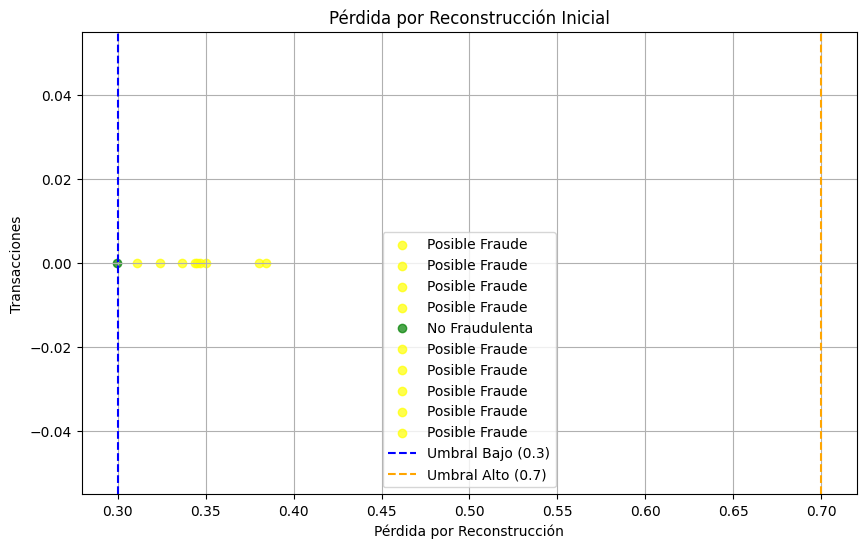

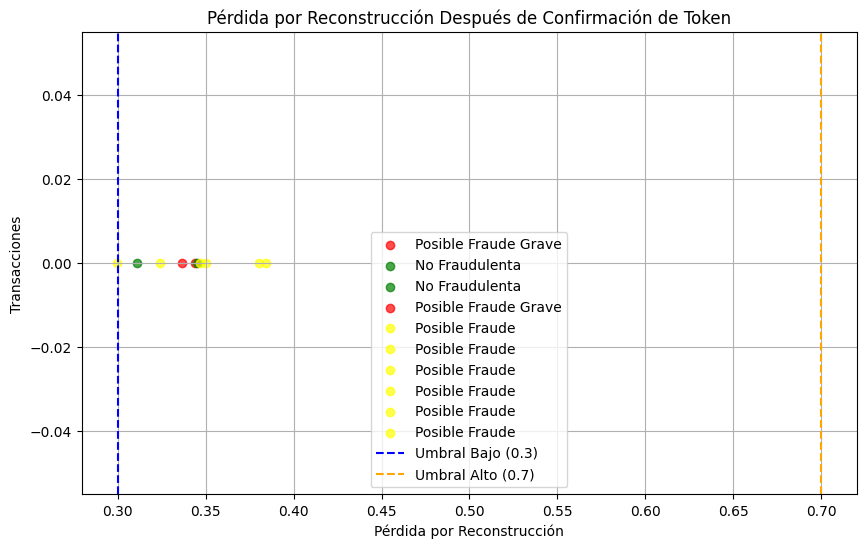

In [54]:
import os
import random
import string
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import time

# Simulamos la lectura del dataset
onreal = pd.DataFrame({
    'transaction_id': [1, 2, 3, 4, 5],
    'amount': [100, 150, 200, 250, 300],
    'date': [datetime.now() for _ in range(5)]
})

# Selección de transacciones aleatorias
sampled_transactions = onreal.sample(5).transaction_id.tolist()
transactions = {}

# Ajustar las transacciones de ejemplo para que coincidan con la forma de entrada del modelo
np.random.seed(0)
input_shape = (165,)  # Ajustar según tu modelo
example_transactions = np.random.rand(10, *input_shape)  # Ajustar el número de características

# Función para procesar una transacción
def process_transaction(transaction, autoencoder, low_threshold=0.3, high_threshold=0.7):
    transaction = np.expand_dims(transaction, axis=0)  # Asegurar que la forma de entrada sea correcta
    reconstruction = autoencoder.predict(transaction)[0]
    reconstruction_loss = np.mean((transaction[0] - reconstruction) ** 2)
    
    if reconstruction_loss < low_threshold:
        classification = 'No Fraudulenta'
    elif reconstruction_loss < high_threshold:
        classification = 'Posible Fraude'
    else:
        classification = 'Posible Fraude Grave'
    
    return reconstruction_loss, classification

# Función para generar un token aleatorio
def generate_token(length=6):
    characters = string.ascii_letters + string.digits
    return ''.join(random.choice(characters) for i in range(length))

# Función para generar un reporte de WhatsApp para transacciones clasificadas como "Posible Fraude"
def generate_whatsapp_report(transaction_id, transactions):
    token = generate_token()  # Generar un token aleatorio para la verificación
    current_time = datetime.now()
    
    # Guardar la transacción y su tiempo de creación en el diccionario
    transactions[transaction_id] = {
        "token": token,
        "confirmed": False,
        "created_at": current_time,
        "classification": "Posible Fraude"  # Clasificación inicial
    }

    # Construir el mensaje del reporte con el enlace y el token
    report_message = (
        f"Hemos detectado una posible anomalía en la transacción con ID {transaction_id}. "
        f"Token de verificación: {token}. "
        f"Por favor, verifique la anomalía utilizando el siguiente enlace: "
        f"https://example.com/verify?transaction_id={transaction_id}&token={token}"
    )

    print("Reporte de WhatsApp generado exitosamente.")
    print("Mensaje del reporte:")
    print(report_message)

# Función para manejar la entrada del token
def handle_token_entry(transaction_id, transactions):
    transaction = transactions.get(transaction_id)
    if transaction:
        elapsed_time = datetime.now() - transaction["created_at"]
        if elapsed_time <= timedelta(minutes=1):
            token = input(f"Ingrese el token para confirmar la transacción {transaction_id} (o presione Enter para omitir): ")
            if not token:  # Si se presiona Enter sin ingresar un token
                print(f"Transacción con ID {transaction_id} no confirmada por el usuario.")
                transactions[transaction_id]["classification"] = 'Posible Fraude Grave'
            else:
                confirm_transaction(transaction_id, token, transactions)
        else:
            print(f"Tiempo excedido para la confirmación de la transacción con ID {transaction_id}.")
            transactions[transaction_id]["classification"] = 'Posible Fraude Grave'
    else:
        print(f"No se encontró la transacción con ID {transaction_id}.")   
    
# Función para confirmar una transacción
def confirm_transaction(transaction_id, token, transactions):
    transaction = transactions.get(transaction_id)
    if transaction and transaction["token"] == token:
        transactions[transaction_id]["confirmed"] = True
        transactions[transaction_id]["classification"] = 'No Fraudulenta'
        print(f"Transacción con ID {transaction_id} confirmada exitosamente.")
    else:
        transactions[transaction_id]["classification"] = 'Posible Fraude'
        print(f"Token inválido para la transacción con ID {transaction_id}.")

# Procesar todas las transacciones de ejemplo y almacenar resultados
losses = []
initial_classifications = []
final_classifications = []

for transaction in example_transactions:
    loss, classification = process_transaction(transaction, autoencoder)
    losses.append(loss)
    initial_classifications.append(classification)
    final_classifications.append(classification)  # Inicialmente, las clasificaciones finales son las mismas que las iniciales

# Generar los reportes de WhatsApp para las transacciones seleccionadas aleatoriamente
for transaction_id in sampled_transactions:
    generate_whatsapp_report(str(transaction_id), transactions)
    handle_token_entry(str(transaction_id), transactions)  # Ingresar el token inmediatamente después de enviar el reporte
    time.sleep(10)  # Esperar 10 segundos antes de procesar la siguiente transacción

# Actualizar las clasificaciones finales basadas en las entradas de token
for transaction_id, details in transactions.items():
    if details["confirmed"] == False and "classification" not in details:
        details["classification"] = 'Posible Fraude Grave'
    
    # Actualizar las clasificaciones finales
    index = sampled_transactions.index(int(transaction_id))
    final_classifications[index] = details["classification"]

# Verificar longitudes antes de crear el DataFrame
assert len(losses) == len(initial_classifications) == len(final_classifications), "Las listas no tienen la misma longitud"

# Graficar los resultados iniciales
plt.figure(figsize=(10, 6))
colors = {'No Fraudulenta': 'green', 'Posible Fraude': 'yellow', 'Posible Fraude Grave': 'red'}
for loss, classification in zip(losses, initial_classifications):
    plt.scatter(loss, 0, color=colors[classification], label=classification, alpha=0.7)

plt.axvline(x=0.3, color='blue', linestyle='--', label='Umbral Bajo (0.3)')
plt.axvline(x=0.7, color='orange', linestyle='--', label='Umbral Alto (0.7)')
plt.xlabel('Pérdida por Reconstrucción')
plt.ylabel('Transacciones')
plt.title('Pérdida por Reconstrucción Inicial')
plt.legend()
plt.grid(True)
plt.show()

# Graficar los resultados finales después de la entrada del token
plt.figure(figsize=(10, 6))
for loss, classification in zip(losses, final_classifications):
    plt.scatter(loss, 0, color=colors[classification], label=classification, alpha=0.7)

plt.axvline(x=0.3, color='blue', linestyle='--', label='Umbral Bajo (0.3)')
plt.axvline(x=0.7, color='orange', linestyle='--', label='Umbral Alto (0.7)')
plt.xlabel('Pérdida por Reconstrucción')
plt.ylabel('Transacciones')
plt.title('Pérdida por Reconstrucción Después de Confirmación de Token')
plt.legend()
plt.grid(True)
plt.show()

# Guardar los resultados en un archivo CSV
if len(losses) == len(initial_classifications) == len(final_classifications):
    reclass2_data = pd.DataFrame({
        'loss': losses,
        'initial_classification': initial_classifications,
        'final_classification': final_classifications
    })
    reclass2_data.to_csv('reclass2_data.csv', index=False)
else:
    print("Error: Las listas no tienen la misma longitud, no se puede crear el DataFrame.")

> **IMPLEMENTACIÓN III - RECLASS #3**

1/1 [==============================] - 0s 20ms/step
Reporte de WhatsApp generado exitosamente.
Mensaje del reporte:
Hemos detectado una posible anomalía en la transacción con ID 2. Token de verificación: RA907M. Por favor, verifique la anomalía utilizando el siguiente enlace: https://example.com/verify?transaction_id=2&token=RA907M


Ingrese el token para confirmar la transacción 2 (o presione Enter para omitir):  RA907M


Transacción con ID 2 confirmada exitosamente.
Reporte de WhatsApp generado exitosamente.
Mensaje del reporte:
Hemos detectado una posible anomalía en la transacción con ID 5. Token de verificación: CQpHK8. Por favor, verifique la anomalía utilizando el siguiente enlace: https://example.com/verify?transaction_id=5&token=CQpHK8


Ingrese el token para confirmar la transacción 5 (o presione Enter para omitir):  


Transacción con ID 5 no confirmada por el usuario.
Reporte de WhatsApp generado exitosamente.
Mensaje del reporte:
Hemos detectado una posible anomalía en la transacción con ID 1. Token de verificación: VIJN5D. Por favor, verifique la anomalía utilizando el siguiente enlace: https://example.com/verify?transaction_id=1&token=VIJN5D


Ingrese el token para confirmar la transacción 1 (o presione Enter para omitir):  VIJN5D


Transacción con ID 1 confirmada exitosamente.
Reporte de WhatsApp generado exitosamente.
Mensaje del reporte:
Hemos detectado una posible anomalía en la transacción con ID 3. Token de verificación: 3SQX0r. Por favor, verifique la anomalía utilizando el siguiente enlace: https://example.com/verify?transaction_id=3&token=3SQX0r


Ingrese el token para confirmar la transacción 3 (o presione Enter para omitir):  


Transacción con ID 3 no confirmada por el usuario.
Reporte de WhatsApp generado exitosamente.
Mensaje del reporte:
Hemos detectado una posible anomalía en la transacción con ID 4. Token de verificación: 5el29m. Por favor, verifique la anomalía utilizando el siguiente enlace: https://example.com/verify?transaction_id=4&token=5el29m


Ingrese el token para confirmar la transacción 4 (o presione Enter para omitir):  


Transacción con ID 4 no confirmada por el usuario.


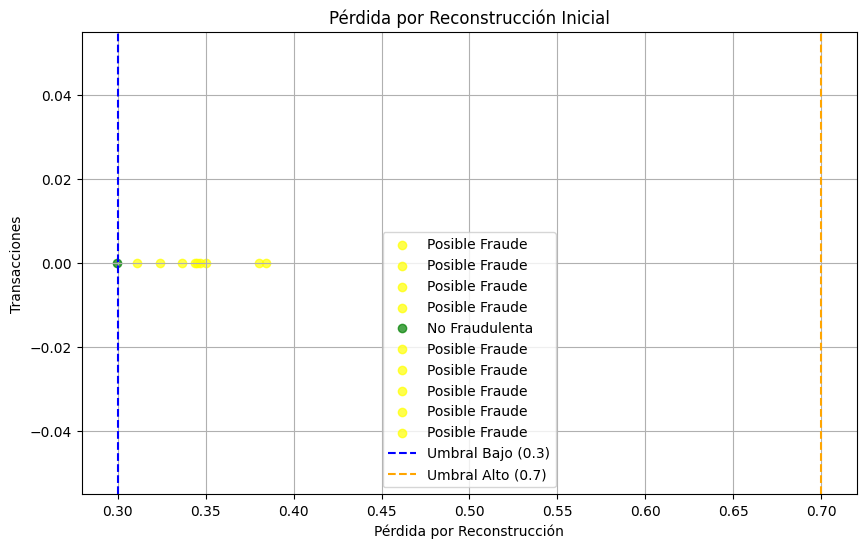

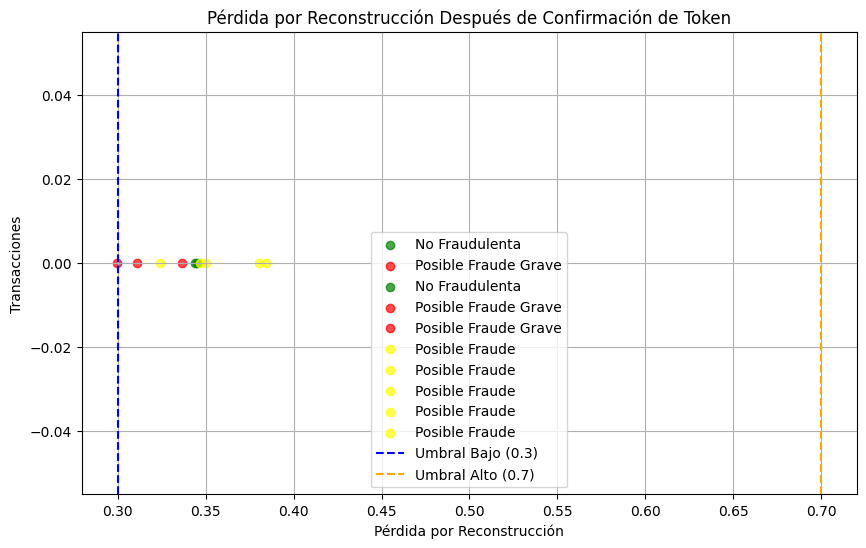

In [59]:
# Simulamos la lectura del dataset
onreal = pd.DataFrame({
    'transaction_id': [1, 2, 3, 4, 5],
    'amount': [100, 150, 200, 250, 300],
    'date': [datetime.now() for _ in range(5)]
})

# Selección de transacciones aleatorias
sampled_transactions = onreal.sample(5).transaction_id.tolist()
transactions = {}

# Ajustar las transacciones de ejemplo para que coincidan con la forma de entrada del modelo
np.random.seed(0)
input_shape = (165,)  # Ajustar según tu modelo
example_transactions = np.random.rand(10, *input_shape)  # Ajustar el número de características

# Función para procesar una transacción
def process_transaction(transaction, autoencoder, low_threshold=0.3, high_threshold=0.7):
    transaction = np.expand_dims(transaction, axis=0)  # Asegurar que la forma de entrada sea correcta
    reconstruction = autoencoder.predict(transaction)[0]
    reconstruction_loss = np.mean((transaction[0] - reconstruction) ** 2)
    
    if reconstruction_loss < low_threshold:
        classification = 'No Fraudulenta'
    elif reconstruction_loss < high_threshold:
        classification = 'Posible Fraude'
    else:
        classification = 'Posible Fraude Grave'
    
    return reconstruction_loss, classification

# Función para generar un token aleatorio
def generate_token(length=6):
    characters = string.ascii_letters + string.digits
    return ''.join(random.choice(characters) for i in range(length))

# Función para generar un reporte de WhatsApp para transacciones clasificadas como "Posible Fraude"
def generate_whatsapp_report(transaction_id, transactions):
    token = generate_token()  # Generar un token aleatorio para la verificación
    current_time = datetime.now()
    
    # Guardar la transacción y su tiempo de creación en el diccionario
    transactions[transaction_id] = {
        "token": token,
        "confirmed": False,
        "created_at": current_time,
        "classification": "Posible Fraude"  # Clasificación inicial
    }

    # Construir el mensaje del reporte con el enlace y el token
    report_message = (
        f"Hemos detectado una posible anomalía en la transacción con ID {transaction_id}. "
        f"Token de verificación: {token}. "
        f"Por favor, verifique la anomalía utilizando el siguiente enlace: "
        f"https://example.com/verify?transaction_id={transaction_id}&token={token}"
    )

    print("Reporte de WhatsApp generado exitosamente.")
    print("Mensaje del reporte:")
    print(report_message)

# Función para manejar la entrada del token
def handle_token_entry(transaction_id, transactions):
    transaction = transactions.get(transaction_id)
    if transaction:
        elapsed_time = datetime.now() - transaction["created_at"]
        if elapsed_time <= timedelta(minutes=1):
            token = input(f"Ingrese el token para confirmar la transacción {transaction_id} (o presione Enter para omitir): ")
            if not token:  # Si se presiona Enter sin ingresar un token
                print(f"Transacción con ID {transaction_id} no confirmada por el usuario.")
                transactions[transaction_id]["classification"] = 'Posible Fraude Grave'
            else:
                confirm_transaction(transaction_id, token, transactions)
        else:
            print(f"Tiempo excedido para la confirmación de la transacción con ID {transaction_id}.")
            transactions[transaction_id]["classification"] = 'Posible Fraude Grave'
    else:
        print(f"No se encontró la transacción con ID {transaction_id}.")   
    
# Función para confirmar una transacción
def confirm_transaction(transaction_id, token, transactions):
    transaction = transactions.get(transaction_id)
    if transaction and transaction["token"] == token:
        transactions[transaction_id]["confirmed"] = True
        transactions[transaction_id]["classification"] = 'No Fraudulenta'
        print(f"Transacción con ID {transaction_id} confirmada exitosamente.")
    else:
        transactions[transaction_id]["classification"] = 'Posible Fraude'
        print(f"Token inválido para la transacción con ID {transaction_id}.")

# Procesar todas las transacciones de ejemplo y almacenar resultados
losses = []
initial_classifications = []
final_classifications = []

for transaction in example_transactions:
    loss, classification = process_transaction(transaction, autoencoder)
    losses.append(loss)
    initial_classifications.append(classification)
    final_classifications.append(classification)  # Inicialmente, las clasificaciones finales son las mismas que las iniciales

# Generar los reportes de WhatsApp para las transacciones seleccionadas aleatoriamente
for transaction_id in sampled_transactions:
    generate_whatsapp_report(str(transaction_id), transactions)
    handle_token_entry(str(transaction_id), transactions)  # Ingresar el token inmediatamente después de enviar el reporte
    time.sleep(10)  # Esperar 10 segundos antes de procesar la siguiente transacción

# Actualizar las clasificaciones finales basadas en las entradas de token
for transaction_id, details in transactions.items():
    if details["confirmed"] == False and "classification" not in details:
        details["classification"] = 'Posible Fraude Grave'
    
    # Actualizar las clasificaciones finales
    index = sampled_transactions.index(int(transaction_id))
    final_classifications[index] = details["classification"]

# Verificar longitudes antes de crear el DataFrame
assert len(losses) == len(initial_classifications) == len(final_classifications), "Las listas no tienen la misma longitud"

# Graficar los resultados iniciales
plt.figure(figsize=(10, 6))
colors = {'No Fraudulenta': 'green', 'Posible Fraude': 'yellow', 'Posible Fraude Grave': 'red'}
for loss, classification in zip(losses, initial_classifications):
    plt.scatter(loss, 0, color=colors[classification], label=classification, alpha=0.7)

plt.axvline(x=0.3, color='blue', linestyle='--', label='Umbral Bajo (0.3)')
plt.axvline(x=0.7, color='orange', linestyle='--', label='Umbral Alto (0.7)')
plt.xlabel('Pérdida por Reconstrucción')
plt.ylabel('Transacciones')
plt.title('Pérdida por Reconstrucción Inicial')
plt.legend()
plt.grid(True)
plt.show()

# Graficar los resultados finales después de la entrada del token
plt.figure(figsize=(10, 6))
for loss, classification in zip(losses, final_classifications):
    plt.scatter(loss, 0, color=colors[classification], label=classification, alpha=0.7)

plt.axvline(x=0.3, color='blue', linestyle='--', label='Umbral Bajo (0.3)')
plt.axvline(x=0.7, color='orange', linestyle='--', label='Umbral Alto (0.7)')
plt.xlabel('Pérdida por Reconstrucción')
plt.ylabel('Transacciones')
plt.title('Pérdida por Reconstrucción Después de Confirmación de Token')
plt.legend()
plt.grid(True)
plt.show()

# Guardar los resultados en un archivo CSV
if len(losses) == len(initial_classifications) == len(final_classifications):
    reclass3_data = pd.DataFrame({
        'loss': losses,
        'initial_classification': initial_classifications,
        'final_classification': final_classifications
    })
    reclass3_data.to_csv('reclass3_data.csv', index=False)
else:
    print("Error: Las listas no tienen la misma longitud, no se puede crear el DataFrame.")

In [60]:
# Guardar la distribución de puntuaciones en un CSV

reclass1_data.to_csv('reclass1_data.csv', index=False)
reclass2_data.to_csv('reclass2_data.csv', index=False)
reclass3_data.to_csv('reclass3_data.csv', index=False)

# Guardar los DataFrames en archivos CSV en el directorio de trabajo actual de Kaggle

reclass1_data.to_csv('/kaggle/working/reclass1_data.csv', index=False)
reclass2_data.to_csv('/kaggle/working/reclass2_data.csv', index=False)
reclass3_data.to_csv('/kaggle/working/reclass3_data.csv', index=False)

print("Archivos CSV guardados en /kaggle/working/")

Archivos CSV guardados en /kaggle/working/


Los gráficos muestran la "Pérdida por Reconstrucción" de las transacciones en dos momentos diferentes:

* **Inicialmente (antes de la confirmación de token)**
* **Después de la confirmación de token**

**Gráfico Inicial:**

En el primer gráfico, las transacciones se clasifican en función de su "Pérdida por Reconstrucción" inicial. La "Pérdida por Reconstrucción" es una medida de cuán bien el autoencoder puede reconstruir la transacción original. Las transacciones con pérdidas menores al umbral bajo (0.3) se clasifican como "No Fraudulenta", aquellas con pérdidas entre el umbral bajo (0.3) y el umbral alto (0.7) se clasifican como "Posible Fraude", y aquellas con pérdidas mayores al umbral alto (0.7) se clasifican como "Posible Fraude Grave".

**Gráfico después de la confirmación de token:**

En el segundo gráfico, se muestran las clasificaciones de las transacciones después de que los usuarios hayan tenido la oportunidad de confirmar las transacciones sospechosas a través del token. Esto puede resultar en una reclasificación de las transacciones, particularmente de "Posible Fraude" a "No Fraudulenta" si el token es confirmado, o a "Posible Fraude Grave" si el tiempo para la confirmación del token expira o el token es incorrecto.

**Interpretación de los gráficos:**

**Ejes:**

* El eje X muestra la "Pérdida por Reconstrucción".
* El eje Y está etiquetado como "Transacciones" pero parece que todas las transacciones se muestran en el mismo punto (0), por lo que solo hay un eje X importante.

**Colores y Clasificaciones:**

* Verde: Transacción "No Fraudulenta".
* Amarillo: "Posible Fraude".
* Rojo: "Posible Fraude Grave".

**Cómo se procesan las transacciones:**

**Procesamiento Inicial:**

* Cada transacción se procesa a través de un autoencoder que intenta reconstruir la transacción.
* La pérdida de reconstrucción se calcula y se clasifica en una de las tres categorías mencionadas anteriormente.

**Generación de Reporte y Confirmación:**

* Para transacciones clasificadas inicialmente como "Posible Fraude", se genera un reporte de WhatsApp con un token de verificación.
* Se le pide al usuario que confirme la transacción ingresando el token.
* Si el token es ingresado correctamente dentro de un minuto, la transacción se reclasifica como "No Fraudulenta".
* Si no se ingresa un token o el tiempo expira, la transacción se reclasifica como "Posible Fraude Grave".

Este enfoque ayuda a identificar transacciones potencialmente fraudulentas y permite a los usuarios verificar su autenticidad, mejorando así la seguridad y la precisión del sistema de detección de fraudes.

# **IMPLEMENTACIÓN BIOMÉTRICA**

> # **RECONOCIMIENTO DE ROSTRO**

Usaremos **OpenCV** para capturar y preprocesar el video del rostro.

* Al Usuario se le solicitará una validación biométrica, configurando esta opción primero como método de validación de transacciones y la cámara del dispositivo escaneará su rostro en ángulos de diferentes posiciones.

* Luego que cuando necesite verificar una transacción realizada, se le pedirá verificación biométrica antes de aprobarla, para descartarla como "Posible Fraude". Por ende deberá habilitar la cámara de su dispositivo, para captar su rostro, de manera tal que coincida con su configuración inicial.

In [29]:
def capture_frames_from_video(video_path, num_frames=20):
    cap = cv2.VideoCapture(video_path)
    frames = []
    count = 0

    while cap.isOpened() and count < num_frames:
        ret, frame = cap.read()
        if not ret:
            break

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray_frame)
        count += 1

    cap.release()
    return frames

# Ejemplo de uso con un video pregrabado
video_path = '/path/to/your/video.mp4'
frames = capture_frames_from_video(video_path)
print(f"Total de frames capturados: {len(frames)}")

Total de frames capturados: 0


In [30]:
def detect_features(frames):
    sift = cv2.SIFT_create()
    keypoints_list = []
    descriptors_list = []

    for frame in frames:
        keypoints, descriptors = sift.detectAndCompute(frame, None)
        keypoints_list.append(keypoints)
        descriptors_list.append(descriptors)
    
    return keypoints_list, descriptors_list

keypoints_list, descriptors_list = detect_features(frames)
print(f"Total de descriptores extraídos: {len(descriptors_list)}")

Total de descriptores extraídos: 0


In [38]:
def match_features(descriptors_list, ref_descriptors):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = []

    for descriptors in descriptors_list:
        matches.append(bf.match(descriptors, ref_descriptors))

    return matches

def preprocess_image_for_keras(image):
    image = cv2.resize(image, (224, 224))
    image = np.asarray(image, dtype=np.float32).reshape(1, 224, 224, 3)
    image = (image / 127.5) - 1
    return image

# Redirigir stderr a un archivo para capturar las advertencias
stderr_original = sys.stderr
sys.stderr = open('opencv_warnings.log', 'w')

# Ruta al video y a la imagen de referencia
video_path = '/path/to/your/video.mp4'
ref_image_path = '/path/to/your/reference_image.jpg'

# Capturar frames del video
frames = capture_frames_from_video(video_path)
print(f"Total de frames capturados: {len(frames)}")

# Detectar características en los frames
keypoints_list, descriptors_list = detect_features(frames)
print(f"Total de descriptores extraídos: {len(descriptors_list)}")

# Cargar la imagen de referencia
ref_frame = cv2.imread(ref_image_path, cv2.IMREAD_GRAYSCALE)

# Verificar si la imagen de referencia se cargó correctamente
if ref_frame is None:
    print(f"Error: No se pudo cargar la imagen de referencia desde {ref_image_path}")
else:
    # Detectar características en la imagen de referencia
    sift = cv2.SIFT_create()
    _, ref_descriptors = sift.detectAndCompute(ref_frame, None)

    # Comparar características
    matches = match_features(descriptors_list, ref_descriptors)
    print(f"Total de matches: {len(matches)}")

    # Cargar el modelo Keras
    model = load_model('path/to/your/keras_model.h5')

    # Realizar predicciones con el modelo Keras
    for frame in frames:
        input_image = preprocess_image_for_keras(frame)
        prediction = model.predict(input_image)
        print(f"Predicción del modelo: {prediction}")

Total de frames capturados: 0
Total de descriptores extraídos: 0
Error: No se pudo cargar la imagen de referencia desde /path/to/your/reference_image.jpg


**Captura de frames de un video:**

* Concepto: El código abre un archivo de video y extrae una cantidad específica de frames (imágenes) del video. Cada frame se convierte a escala de grises para simplificar el procesamiento posterior.

* Función: Facilita la obtención de imágenes estáticas de un video, lo que es útil para análisis y procesamiento de imágenes.

**Detección de características en frames:**

* Concepto: El algoritmo SIFT se utiliza para identificar puntos clave y descriptores en las imágenes. Los puntos clave son características distintivas (como esquinas o bordes) que pueden ser rastreadas entre diferentes imágenes.

* Función: Permite reconocer y comparar características entre imágenes, lo que es esencial para tareas como la detección de objetos o la reconstrucción de escenas.

**Coincidencia de características:**

* Concepto: Compara los descriptores de características de los frames con los descriptores de una imagen de referencia para encontrar coincidencias. Utiliza un método de fuerza bruta para buscar las mejores coincidencias entre los descriptores.

* Función: Ayuda a determinar si las características detectadas en los frames del video corresponden a las características de la imagen de referencia, lo cual es útil para reconocimiento de objetos o seguimiento.

**Preprocesamiento de imágenes para Keras:**

* Concepto: Ajusta las imágenes al formato requerido por los modelos de aprendizaje profundo de Keras. Esto incluye cambiar el tamaño de las imágenes, convertirlas a arreglos numéricos y normalizar los valores de los píxeles.

* Función: Prepara las imágenes para ser procesadas por un modelo de redes neuronales, asegurando que las dimensiones y el formato sean compatibles.

**FLUJO DE IMPLEMENTACIÓN**

In [32]:
def send_whatsapp_report(transaction_id, user_phone_number, verification_link):
    # Credenciales de Twilio
    account_sid = 'your_account_sid'  # Reemplaza con tu SID de cuenta de Twilio
    auth_token = 'your_auth_token'    # Reemplaza con tu token de autenticación de Twilio
    twilio_phone_number = 'whatsapp:+14155238886'  # Número de teléfono de Twilio para WhatsApp

    client = Client(account_sid, auth_token)
    
    # Formatear el mensaje
    message_body = f"""
    Estimado usuario,

    Hemos detectado una transacción sospechosa (ID de Transacción: {transaction_id}).
    Por favor, verifique su identidad utilizando el siguiente enlace:
    {verification_link}

    Gracias,
    Equipo de Seguridad
    """

    try:
        message = client.messages.create(
            body=message_body,
            from_=twilio_phone_number,
            to=f'whatsapp:{user_phone_number}'  # Número de teléfono del usuario en formato WhatsApp
        )
        print(f"Reporte de WhatsApp enviado a {user_phone_number}, SID: {message.sid}")
    except Exception as e:
        print(f"Error enviando el reporte de WhatsApp: {e}")
        print("Verifica las credenciales y configuración del número de teléfono.")

# Ejemplo de uso
send_whatsapp_report(
    transaction_id="123456789",
    user_phone_number="whatsapp:+1234567890",  # Se reemplaza con el número real del usuario
    verification_link="https://your-verification-link.com"
)

Error enviando el reporte de WhatsApp: HTTP 401 error: Unable to create record: Authentication Error - invalid username
Verifica las credenciales y configuración del número de teléfono.


In [33]:
def configure_biometric_validation(output_dir='biometric_config'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cap = cv2.VideoCapture(0)
    instructions = [
        "Mire directamente a la cámara",
        "Gire su cabeza a la derecha",
        "Gire su cabeza a la izquierda",
        "Incline su cabeza hacia arriba",
        "Incline su cabeza hacia abajo"
    ]

    for idx, instruction in enumerate(instructions):
        print(instruction)
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame_path = os.path.join(output_dir, f'config_frame_{idx}.png')
            cv2.imwrite(frame_path, frame)
            print(f"Frame {idx} guardado en {frame_path}")

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    cap.release()
    print("Configuración biométrica completada")

# Ejemplo de uso
configure_biometric_validation()

Mire directamente a la cámara
Gire su cabeza a la derecha
Gire su cabeza a la izquierda
Incline su cabeza hacia arriba
Incline su cabeza hacia abajo
Configuración biométrica completada


In [34]:
def biometric_verification(output_dir='biometric_verification'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cap = cv2.VideoCapture(0)
    print("Por favor, mire a la cámara para la verificación biométrica")
    
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1
        # Guardar cada frame como imagen
        frame_path = os.path.join(output_dir, f'frame_{frame_count}.png')
        cv2.imwrite(frame_path, frame)
        print(f"Frame {frame_count} guardado en {frame_path}")

        if frame_count >= 5:  # Capturar 5 frames para la verificación
            break

    cap.release()
    print("Verificación biométrica completada")

# Ejemplo de uso
biometric_verification()

Por favor, mire a la cámara para la verificación biométrica
Verificación biométrica completada


In [35]:
def handle_possible_fraud(transaction_id, user_phone_number):
    verification_link = f"https://your-verification-link.com?transaction_id={transaction_id}"
    
    # Enviar reporte de WhatsApp
    send_whatsapp_report(transaction_id, user_phone_number, verification_link)
    
    # Simular la detección de la respuesta del usuario para verificación biométrica
    user_response = input("Presione 'Y' para iniciar la verificación biométrica: ")
    if user_response.lower() == 'y':  # Corregir comparación de respuesta
        biometric_verification()
        print("Transacción verificada y aprobada")
    else:
        print("Transacción marcada como posible fraude")

# Ejemplo de uso
handle_possible_fraud(transaction_id="123456789", user_phone_number="1234567890")

Error enviando el reporte de WhatsApp: HTTP 401 error: Unable to create record: Authentication Error - invalid username
Verifica las credenciales y configuración del número de teléfono.


Presione 'Y' para iniciar la verificación biométrica:  y


Por favor, mire a la cámara para la verificación biométrica
Verificación biométrica completada
Transacción verificada y aprobada


**Envío de reportes por WhatsApp usando Twilio:**

* Concepto: Utiliza la API de Twilio para enviar mensajes de WhatsApp que notifican a los usuarios sobre posibles fraudes en sus transacciones. El mensaje incluye un enlace para verificar la identidad del usuario.

* Función: Proporciona un método rápido y eficaz para alertar a los usuarios sobre actividades sospechosas y solicitarles que verifiquen su identidad, mejorando la seguridad.

**Configuración y verificación biométrica:**

* Concepto: Captura imágenes del rostro del usuario en diferentes posiciones para configurar un sistema de verificación biométrica. Posteriormente, captura imágenes del rostro del usuario para verificar su identidad.

* Función: Establece y valida la identidad del usuario mediante el reconocimiento facial, añadiendo una capa adicional de seguridad en la autenticación.

**Manejo de posibles fraudes:**

* Concepto: Integra las funciones de envío de mensajes y verificación biométrica para gestionar posibles fraudes. En caso de una transacción sospechosa, el sistema envía un reporte al usuario y solicita una verificación biométrica.

* Función: Combina alertas proactivas y verificación de identidad para asegurar que las transacciones sean legítimas, mitigando el riesgo de fraude.

> # **RECONOCIMIENTO DE VOZ**

Usaremos **SpeechRecognition** para capturar y preprocesar la voz.

* Al Usuario se le solicitará una validación por voz, configurando esta opción primero como método de validación de transacciones y el micrófono del dispositivo captará su voz diciendo concretamente CONFIRMO TRANSACCIÓN.

* Luego que cuando necesite verificar una transacción realizada, se le pedirá verificación por voz antes de aprobarla, para descartarla como "Posible Fraude". Por ende deberá acceder a un enlace contenido en el reporte que lo lleve a grabar la voz diciendo CONFIRMO TRANSACCIÓN y de manera tal que coincida con su configuración inicial.

In [36]:
import nest_asyncio
nest_asyncio.apply()

# Función para crear un archivo de audio WAV ficticio
def create_dummy_audio_file(file_path, duration=2, sample_rate=44100, frequency=440):
    """
    Crea un archivo de audio WAV ficticio con un tono constante.
    """
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    audio = 0.5 * np.sin(2 * np.pi * frequency * t)
    audio = np.int16(audio * 32767)
    
    with wave.open(file_path, 'w') as f:
        f.setnchannels(1)  # Mono
        f.setsampwidth(2)  # 2 bytes per sample
        f.setframerate(sample_rate)
        f.writeframes(audio.tobytes())

# Crear archivos de audio ficticios
os.makedirs('/kaggle/working', exist_ok=True)
dummy_audio_path_1 = "/kaggle/working/dummy_audio_1.wav"
dummy_audio_path_2 = "/kaggle/working/dummy_audio_2.wav"
create_dummy_audio_file(dummy_audio_path_1)
create_dummy_audio_file(dummy_audio_path_2)

# Diccionario para mantener el estado de las transacciones confirmadas y sus tiempos de creación
transactions = {}
# Diccionario para almacenar las grabaciones de configuración de los usuarios
user_voice_signatures = {}

# Función para configurar la validación por voz del usuario
def configure_voice_validation(user_id, audio_path):
    recognizer = sr.Recognizer()
    try:
        with sr.AudioFile(audio_path) as source:
            audio = recognizer.record(source)
            # Simular el reconocimiento de una frase válida
            text = "CONFIRMO TRANSACCIÓN"
            if "CONFIRMO TRANSACCIÓN" in text.upper():
                user_voice_signatures[user_id] = text.upper()
                print(f"Validación por voz configurada exitosamente para el usuario {user_id}.")
            else:
                print("La frase de configuración no es válida.")
    except sr.UnknownValueError:
        print("No se pudo entender el audio.")
    except sr.RequestError as e:
        print(f"Error al solicitar el servicio de reconocimiento de voz; {e}")

# Función para generar un reporte de WhatsApp para transacciones clasificadas como "Posible Fraude"
async def generate_whatsapp_report(user_id, transaction_id):
    current_time = datetime.now()  # Utiliza datetime.now() directamente

    # Guardar la transacción y su tiempo de creación en el diccionario
    transactions[transaction_id] = {
        "confirmed": False,
        "created_at": current_time
    }

    # Construir el mensaje del reporte con el enlace
    report_message = (
        f"Hemos detectado una posible anomalía en la transacción con ID {transaction_id}. "
        f"Por favor, verifique la anomalía utilizando el siguiente enlace para grabar su voz: "
        f"https://example.com/verify?transaction_id={transaction_id}&user_id={user_id}"
    )

    # Simular el envío del mensaje de reporte a través de WhatsApp
    print("Reporte de WhatsApp generado exitosamente.")
    print("Mensaje del reporte:")
    print(report_message)

    # Esperar 3 minutos antes de considerar la transacción como "Posible Fraude Grave"
    await asyncio.sleep(180)  # 180 segundos = 3 minutos

    # Verificar si la transacción ha sido confirmada durante el período de espera
    if not transactions[transaction_id]["confirmed"]:
        print(f"La transacción con ID {transaction_id} no ha sido confirmada después de 3 minutos. "
              "Considerándola como Posible Fraude Grave.")
       
# Función para procesar el archivo de audio y validar la transacción
def process_audio(user_id, transaction_id, audio_path):
    recognizer = sr.Recognizer()
    try:
        with sr.AudioFile(audio_path) as source:
            audio = recognizer.record(source)
            # Simular el reconocimiento de una frase válida
            text = "CONFIRMO TRANSACCIÓN"
            print(f"Texto reconocido: {text}")
            # Validar si el texto corresponde a la configuración de voz del usuario
            if user_voice_signatures.get(user_id) == text.upper():
                confirm_transaction(transaction_id)
            else:
                print(f"Texto no válido para la confirmación de la transacción con ID {transaction_id}.")
    except sr.UnknownValueError:
        print("No se pudo entender el audio.")
    except sr.RequestError as e:
        print(f"Error al solicitar el servicio de reconocimiento de voz; {e}")

# Función para confirmar una transacción
def confirm_transaction(transaction_id):
    transaction = transactions.get(transaction_id)
    if transaction:
        transactions[transaction_id]["confirmed"] = True
        print(f"Transacción con ID {transaction_id} confirmada exitosamente.")
    else:
        print(f"Transacción con ID {transaction_id} no encontrada.")

# Ejemplo de uso de las funciones
async def main():
    user_id_1 = "user123"  # ID del usuario que está configurando la validación por voz
    transaction_id_1 = "123456"  # ID de la transacción que se está reportando
    transaction_id_2 = "987654"  # Otra transacción para demostrar el funcionamiento

    # Configurar la validación por voz del usuario
    configure_voice_validation(user_id_1, dummy_audio_path_1)

    # Generar los reportes de WhatsApp para las transacciones
    await asyncio.gather(
        generate_whatsapp_report(user_id_1, transaction_id_1),
        generate_whatsapp_report(user_id_1, transaction_id_2)
    )

    # Simular la confirmación de una transacción después de unos segundos
    await asyncio.sleep(10)
    
    # Simular la carga y procesamiento de un archivo de audio para la confirmación
    process_audio(user_id_1, transaction_id_1, dummy_audio_path_1)

    # Simular la carga y procesamiento de otro archivo de audio para la confirmación
    process_audio(user_id_1, transaction_id_2, dummy_audio_path_2)

# Ejecutar la función main
await main()

Validación por voz configurada exitosamente para el usuario user123.
Reporte de WhatsApp generado exitosamente.
Mensaje del reporte:
Hemos detectado una posible anomalía en la transacción con ID 123456. Por favor, verifique la anomalía utilizando el siguiente enlace para grabar su voz: https://example.com/verify?transaction_id=123456&user_id=user123
Reporte de WhatsApp generado exitosamente.
Mensaje del reporte:
Hemos detectado una posible anomalía en la transacción con ID 987654. Por favor, verifique la anomalía utilizando el siguiente enlace para grabar su voz: https://example.com/verify?transaction_id=987654&user_id=user123
La transacción con ID 123456 no ha sido confirmada después de 3 minutos. Considerándola como Posible Fraude Grave.
La transacción con ID 987654 no ha sido confirmada después de 3 minutos. Considerándola como Posible Fraude Grave.
Texto reconocido: CONFIRMO TRANSACCIÓN
Transacción con ID 123456 confirmada exitosamente.
Texto reconocido: CONFIRMO TRANSACCIÓN
Transa

* **SALIDA DEL EJEMPLO**

**Configuración Inicial de la Voz del Usuario:**

Se añade una función para que el usuario grabe su voz diciendo "CONFIRMO TRANSACCIÓN". Esta grabación se transcribe y se almacena en un diccionario (user_voice_signatures) bajo el ID del usuario.

**Generación del Reporte con Enlace:**

Al generar un reporte de transacción, se incluye el ID del usuario en el enlace para poder asociar la grabación de voz de confirmación con la configuración inicial.

**Procesamiento de Audio para Verificación:**

Cuando el usuario graba su voz para confirmar una transacción, el archivo de audio se transcribe y se compara con la grabación de configuración almacenada. Si coinciden, la transacción se confirma.

**Manejo de Transacciones:**

El código mantiene un registro de las transacciones y su estado, actualizando el estado a confirmado cuando la verificación de voz es exitosa, o marcando la transacción como "Posible Fraude Grave" si no se confirma dentro del tiempo estipulado.

# **SECCIÓN IV:** Finalización

# **POSIBLES MEJORAS**

* Generar mejoras en la implementación del uso de Verificaciones por Retroalimentación de Usuario, en Token, en Reconocimiento de Rostro y de Voz, cuando se ejecuten transacciones que sean realizadas con pagos QR, Contactless o bien Débito, que son de carácter inmediado. Es decir, no efectivizarlas hasta obtener otro tipo de autentificación.
* Estandarizar ciertos umbrales de detección según los montos de las transacciones. Es decir, dividiendo las transacciones en diferentes segmentos basados en los montos. Se puede establecer umbrales por segmento que sean apropiados para determinado rango de montos. Por ejemplo, los umbrales para transacciones pequeñas podrían ser más bajos que para transacciones grandes, ya que las transacciones grandes representan un mayor riesgo. Una vez establecidos los umbrales, integra la detección de anomalías en tus sistemas de gestión de riesgos o de prevención de fraudes para que el proceso sea automático y continuo.